In [5]:
## for each masks, check the overlaps with the staining stacks, calculate the histogram 
## and save this file for the analysis

import time
import numpy as np
import matplotlib.pyplot as plt
import tifffile

import statistics
from scipy import stats
from numba import njit
import pickle
import json
import util as ut




ModuleNotFoundError: No module named 'util'

In [ ]:
@njit(fastmath=True)
def fast_cal(mask, stacks):
    """
    Generate the list of voxels from the staining stack where intensity is greater than zero for the given region 
    arguments:
        mask: region stack  
        stacks: gene expression stack
    returns:
        mask_list: list of voxels with value
    """  
    mask_list = []
    for i in range(len(mask)):
        for j in range(len(mask[i])):
            for k in range(len(mask[i][j])):
                if mask[i][j][k] == 0:
                    pass
                else:
                    mask_list.append(stacks[i][j][k])
    return mask_list

def calculate_histogram(mask, stacks, name):
    """
    Compute the histogram of staining stack in the region
    arguments:
        mask: region stack  
        stacks: gene expression stack
        name: name of the region
    returns:
        densitys: histogram density
    """  
    mask = mask.astype('float') 
    mask_list = fast_cal(mask, stacks)
    print(mask_list)
    densitys, bin_edges = np.histogram(mask_list, bins=256, range=(0,255), density=False )
    plt.plot(np.arange(0,256,1), densitys)
    plt.title("mask is %s" % name)
    plt.show()
    return densitys

import os

def compute_densities(regions, regions_folder, save_folder, staining_name, specie, staining_stack_url):
    """
    Compute the staining expression density across regions and store it as pickle data  
    """
    # Ensure save_folder exists before saving
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    # Read the staining stack
    staining_stack = tifffile.imread(staining_stack_url)
    distribution_data_set = []

    for i, name in enumerate(regions):
        print(i, name)
        m_mask = tifffile.imread(os.path.join(regions_folder, f"{name}.tif"))
        densitys = calculate_histogram(mask=m_mask, stacks=staining_stack, name=name)
        d = {"region_name": name, "density_plt": densitys}
        distribution_data_set.append(d)
    
    filename = os.path.join(save_folder, f"{staining_name}_distribution_{specie}_new.pkl")
    print("Saving to:", filename)
    ut.write_pickle(distribution_data_set, filename)



In [2]:
import matplotlib.gridspec as gridspec

def add_element(lists, max_value):
    listss =  ([0] + np.array(lists).tolist() + [0])/max_value
    return listss


def get_number_ave_thres(distribution, max_threshold, bottom_threshold, top_threshold):
    """
    Compute the normalized average value in the range. Range is precomputed in such a way 
    that top 1% of the staining pixels are selected across the stack
    arguments:
        distribution: histogram 
        max_threshold: max intensity in the staining stack
        bottom_threshold: min value of the selected range
        top_threshold: max value of the selected range
    returns:
        ave_valu: average intensity value
    """ 
    new_dis = []
    xrange = np.arange(0,256,1)
    for i in range(len(xrange)):
        if i < bottom_threshold:
            new_dis.append(0)
        else:
            if i > top_threshold:
                new_dis.append(0)
            else:
                new_dis.append(distribution[i])
               
    ave_valu = np.dot(new_dis, xrange)/(np.sum(distribution)*max_threshold)
         
    return ave_valu


def manhattan_plots(precomputed_threshold_file, regions, colors, model_organism_list, staining_names_list, save_folder):
    """
    Manhattan plot
    arguments:
        precomputed_threshold_file: histogram 
        regions: list of regions 
        colors: colors for different model organisms
        model_organism_list: list of model organisms
        staining_names_list: list of staining
        save_folder: folder for storing plots
    returns:
        
    """ 
    threhold_values_map={}
    x = np.arange(0, len(regions)+1, 1) 
    xs =  x.tolist() + [len(regions)]
    threhold_values_list=ut.read_json(precomputed_threshold_file)
    for val_data in threhold_values_list:
        item_name=val_data['name']
        threhold_values_map[item_name]=val_data
    fig, axs = plt.subplots(len(staining_names_list), 2, figsize=(10, len(staining_names_list)*2))
    axs = axs.flat
    for list_i, list_gene_name in enumerate(staining_names_list):
        threshold_current=threhold_values_map[list_gene_name]
        bottom_list=threshold_current['lower_threshold']
        top_list=threshold_current['upper_threshold']
        for fish_i, fish_name  in enumerate(model_organism_list):
            # make figure subplot
            top_threshold=top_list[fish_i]
            bottom_threshold=bottom_list[fish_i]
            pickle_file_name=r'%s/%s_distribution_%s_new.pkl' % (save_folder, list_gene_name, fish_name)
            print(pickle_file_name)
            # read pickle
            distribution_map={}
            distribution_data=ut.read_pickle(pickle_file_name)
            for dist_data in distribution_data:
                reg_name=dist_data["region_name"]
                distribution_map[reg_name]=dist_data["density_plt"]
           
        
            ave_vals, top_med_vals = [],[]
            for i, name in enumerate(regions):
                if name in distribution_map:
                    regionname = name
                    data = distribution_map[name]
                    ave_val = get_number_ave_thres(distribution=data, max_threshold=top_threshold,
                                           bottom_threshold=bottom_threshold, top_threshold=top_threshold)
                else:
                    ave_val=0.0
                ave_vals.append(ave_val)

            max_value = max(ave_vals)
            ave_vals_MP = add_element(ave_vals, max_value)

            axs[2*list_i+0].step(xs, ave_vals_MP, color=colors[fish_i], alpha=0.7)
            axs[2*list_i+0].set_title("%s, ave" % staining_names_list[list_i])
            
    plt.tight_layout()
    plt.savefig("%s/manhattan_plot_test_thresholded_%s.svg" % (save_folder, list_gene_name))
    plt.show()


['Telencephalon', 'Diencephalon', 'Midbrain', 'Hindbrain', 'Spinal Cord', 'Ganglia']
0 Olfactory Bulb


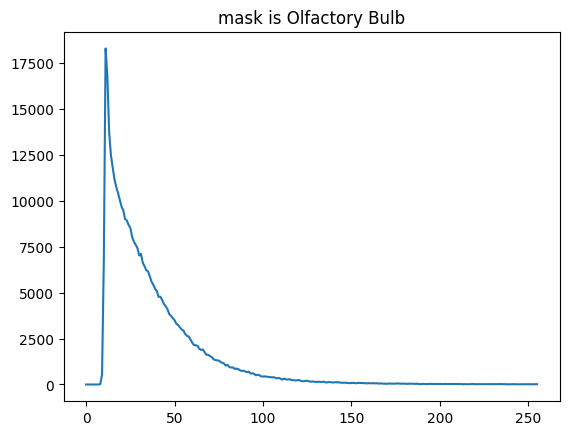

1 Pallium


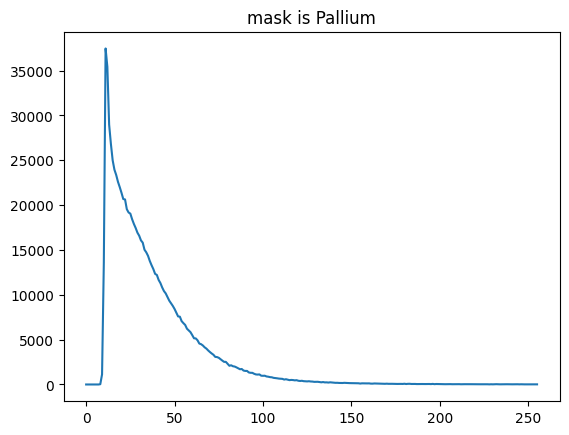

2 Subpallium


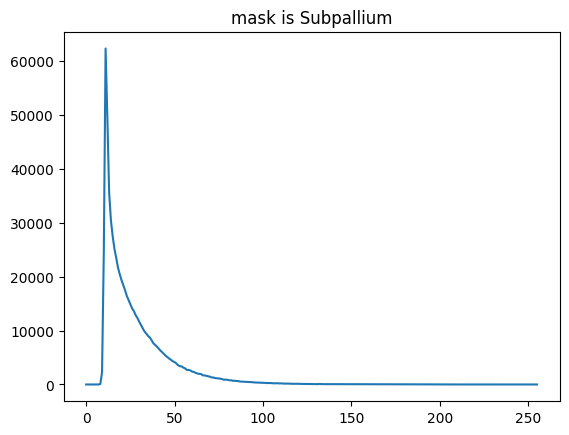

3 Pineal


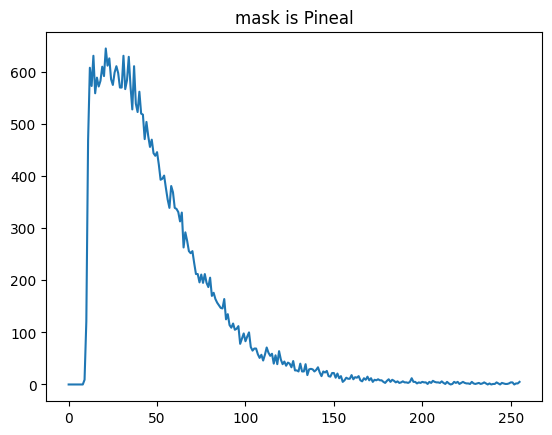

4 Habenula


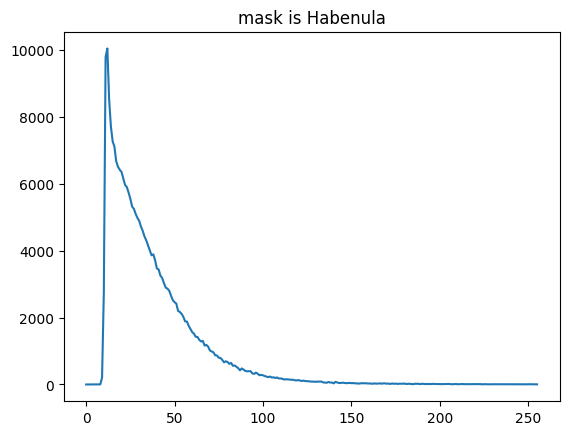

5 Optic Tract and Accessory Optic System


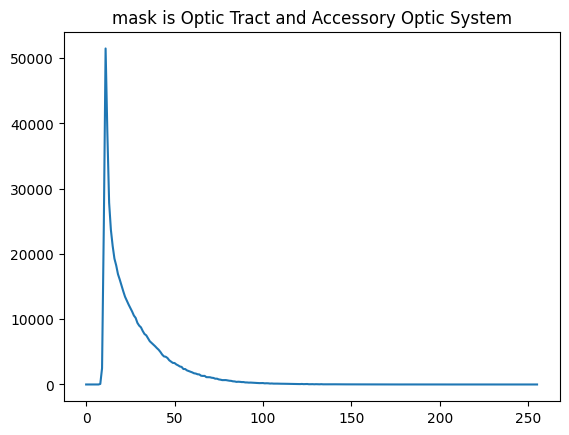

6 Retinal Arborization Field 1 (AF1, Approximate Location)


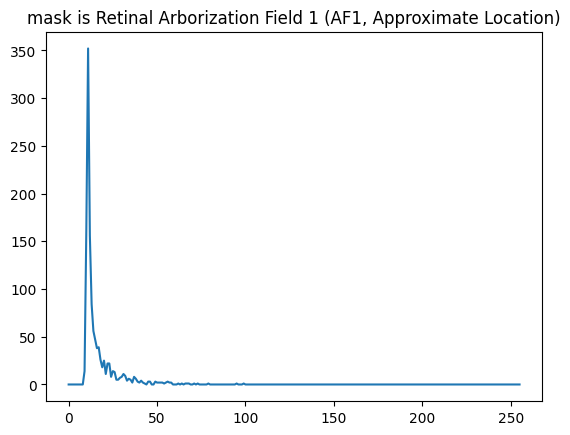

7 Retinal Arborization Field 2 (AF2, Approximate Location)


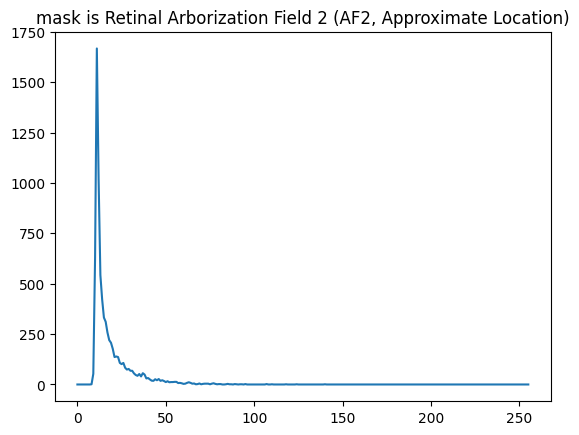

8 Retinal Arborization Field 3 (AF3)


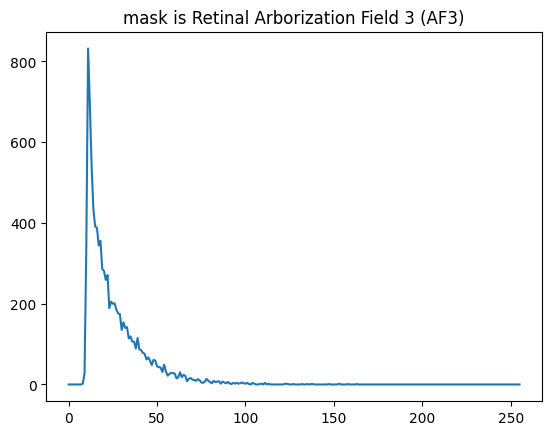

9 Retinal Arborization Field 4 (AF4)


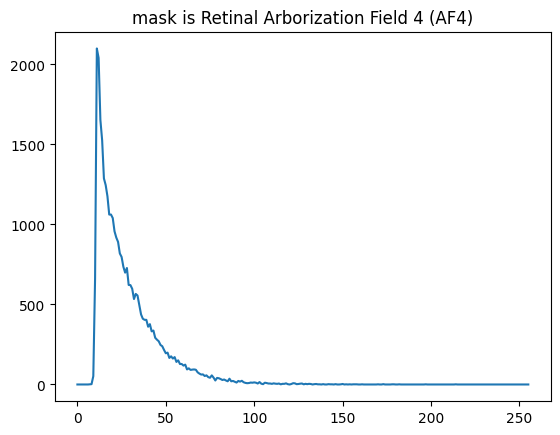

10 Retinal Arborization Field 5 (AF5)


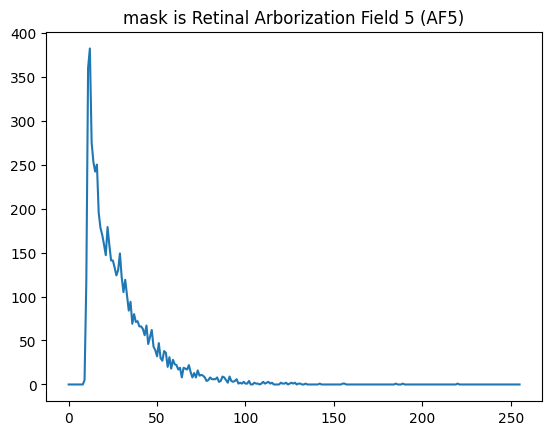

11 Retinal Arborization Field 6 (AF6)


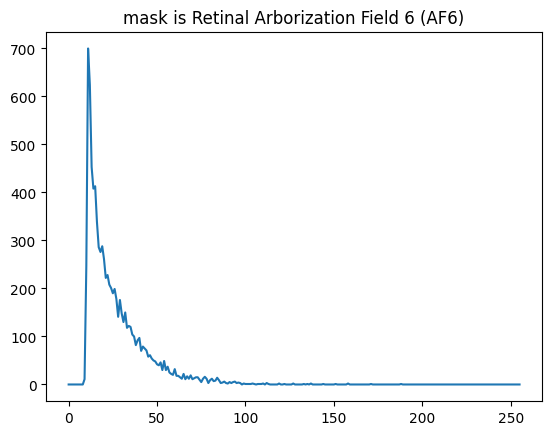

12 Retinal Arborization Field 7 (AF7)


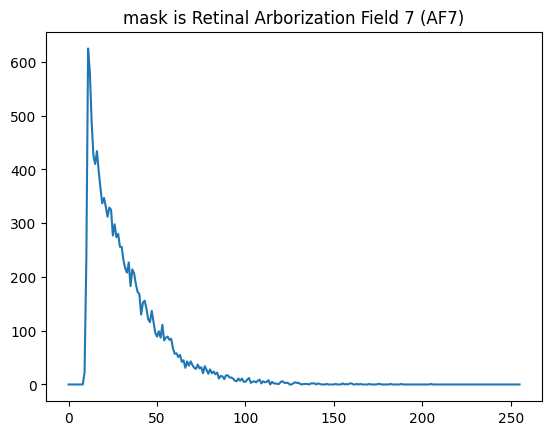

13 Retinal Arborization Field 8 (AF8)


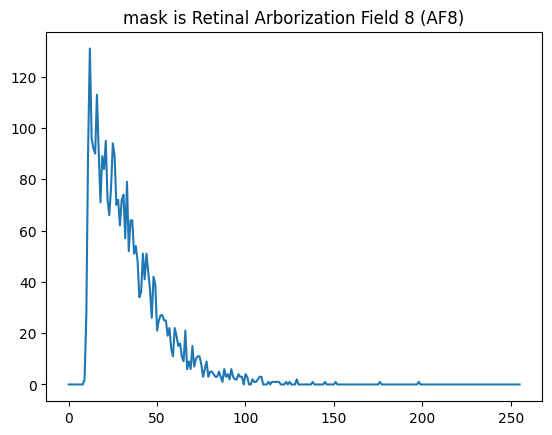

14 Retinal Arborization Field 9 (AF9)


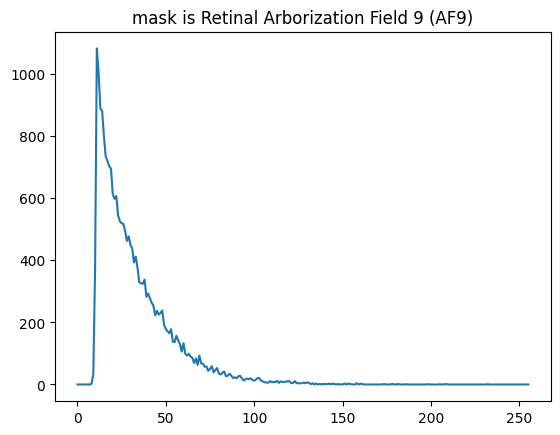

15 Pretectum


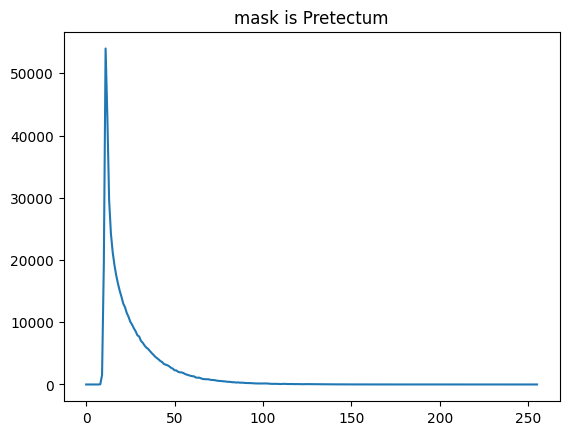

16 Dorsal Thalamus


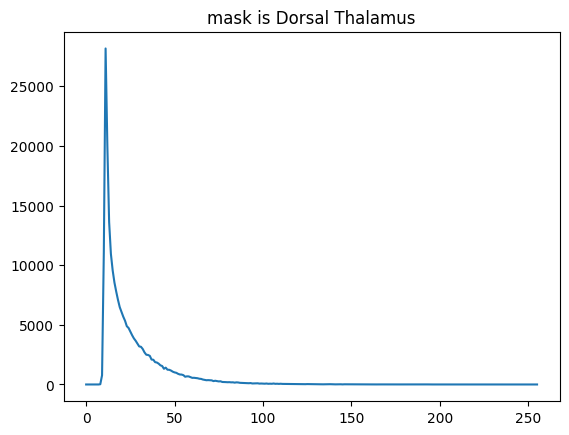

17 Ventral Thalamus


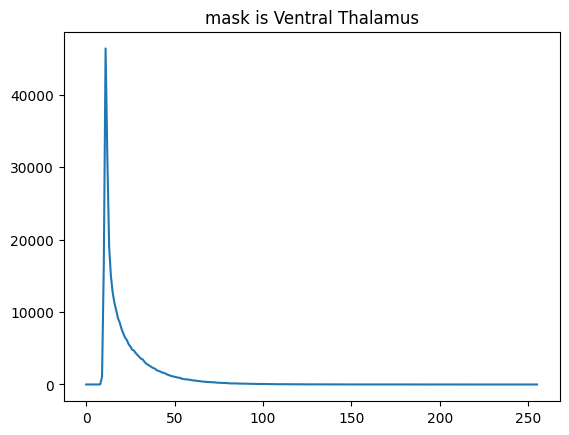

18 Preoptic Area


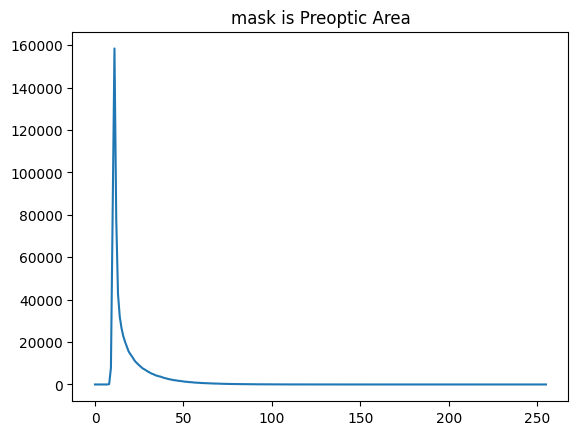

19 Posterior Tuberculum


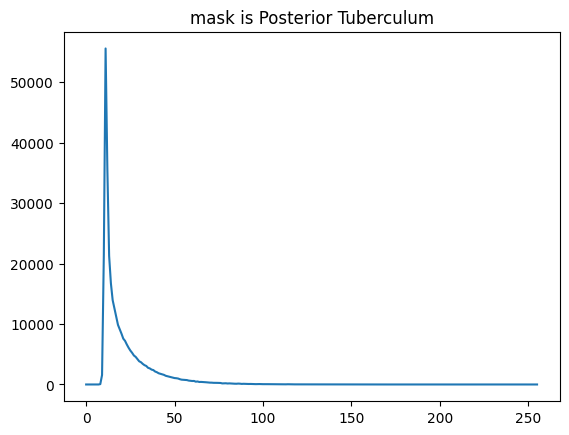

20 Preglomerular Complex (approximate area)


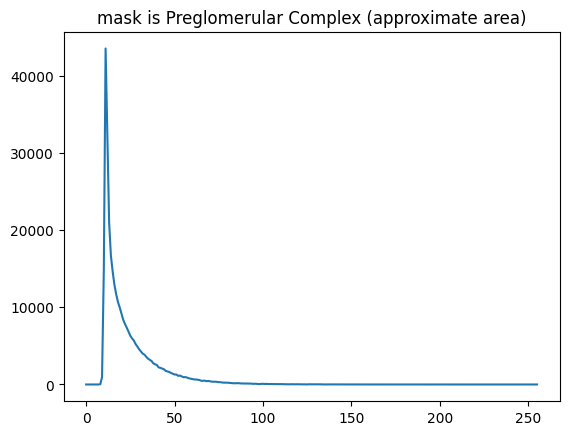

21 Rostral Hypothalamus


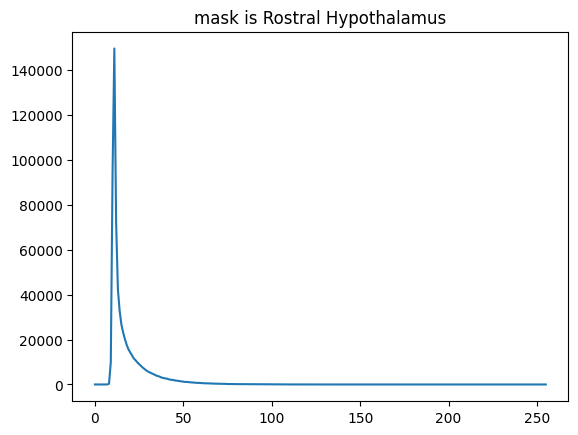

22 Intermediate Hypothalamus


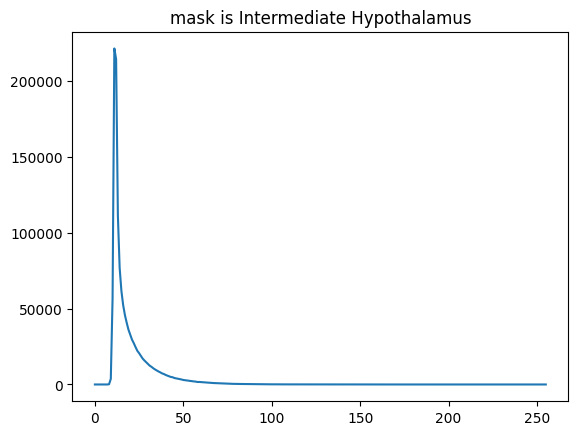

23 Diffuse Nucleus of the Intermediate Hypothalamus


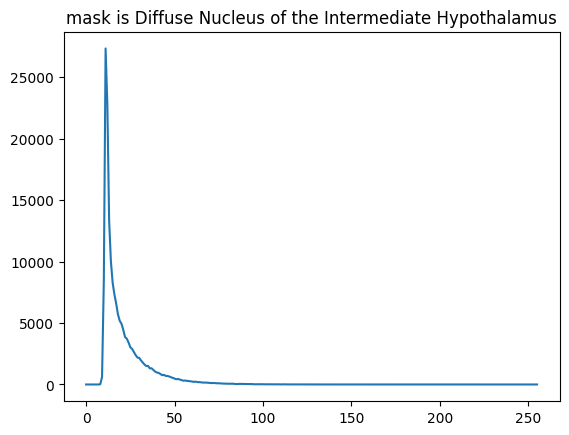

24 Caudal Hypothalamus


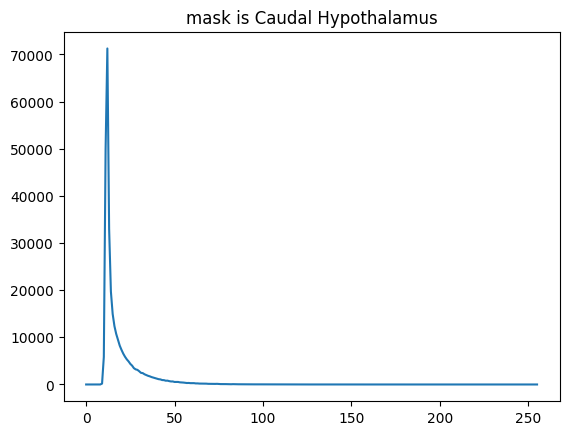

25 Pituitary


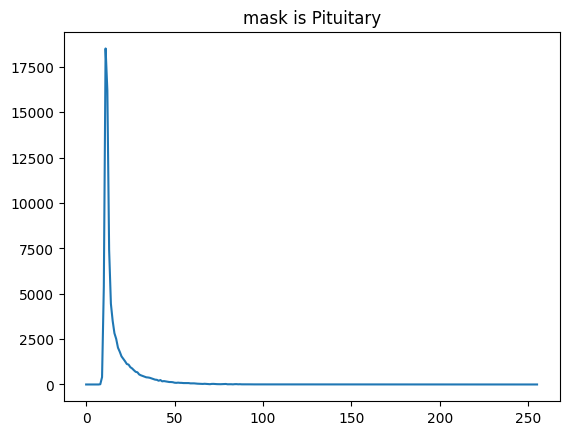

26 Torus Longitudinalis


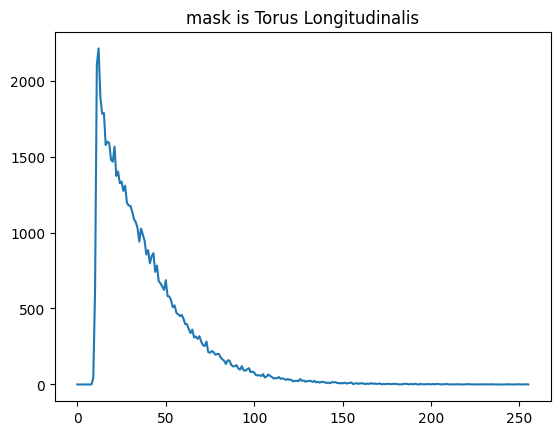

27 Torus Semicircularis


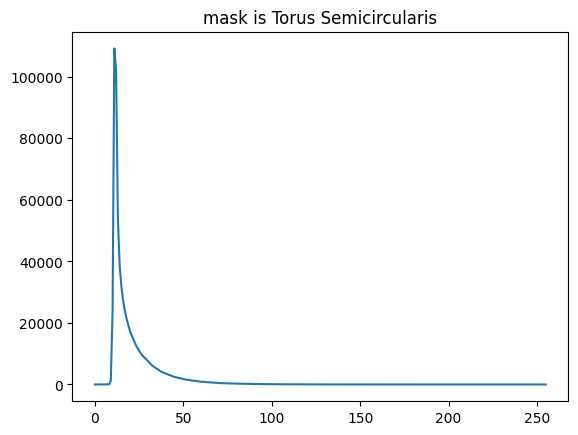

28 Neuropil


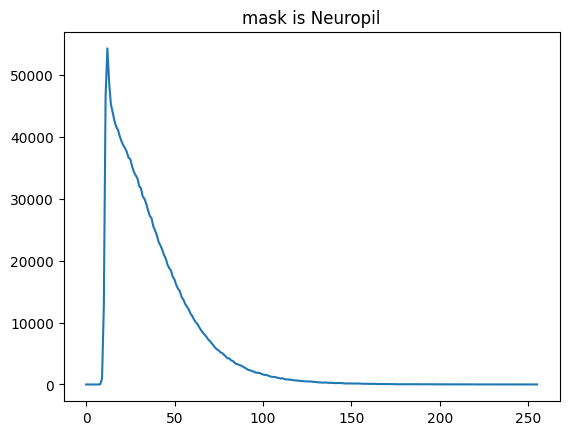

29 Stratum Periventriculare


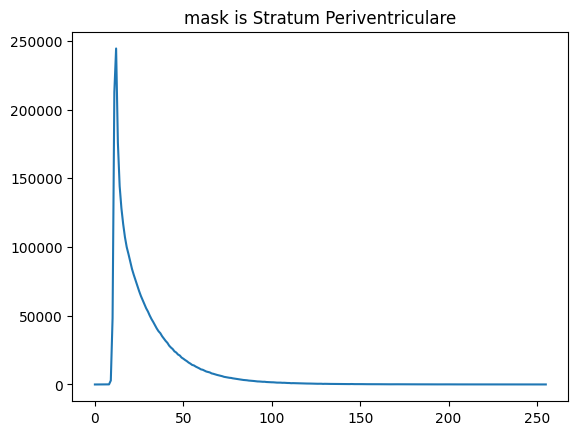

30 Tegmentum


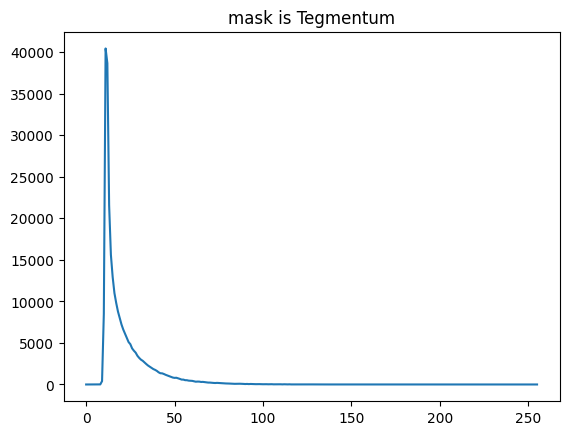

31 Oculomotor Nucleus nIII


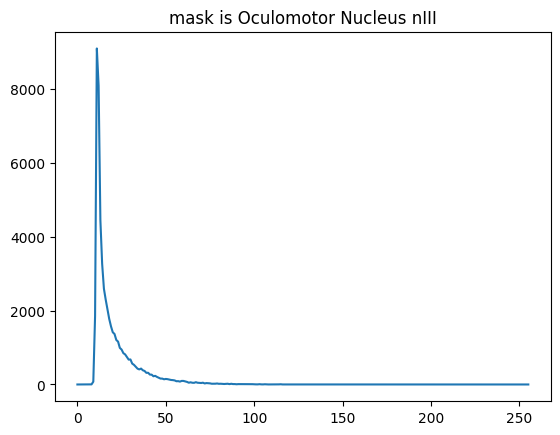

32 NucMLF (nucleus of the medial longitudinal fascicle)


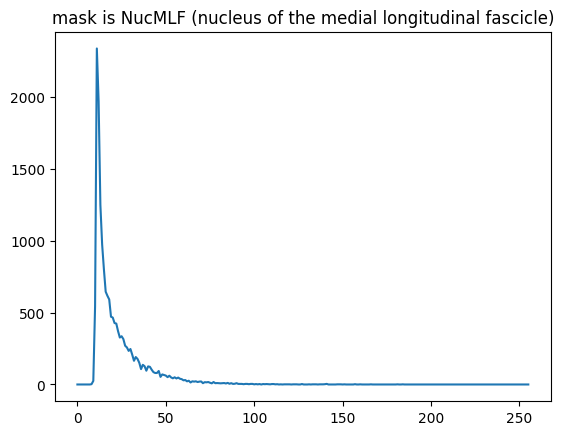

33 Cerebellum


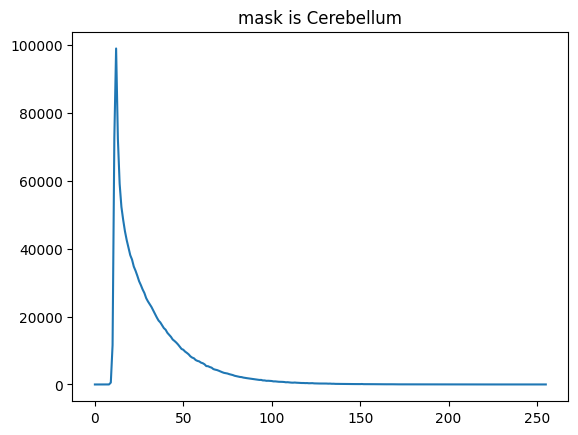

34 Valvula Cerebellum


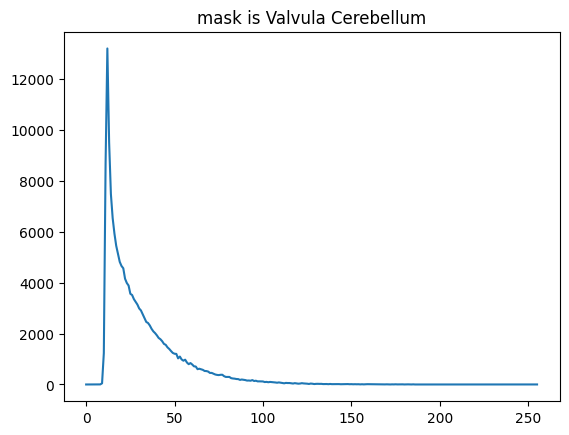

35 Cerebellar Corpus


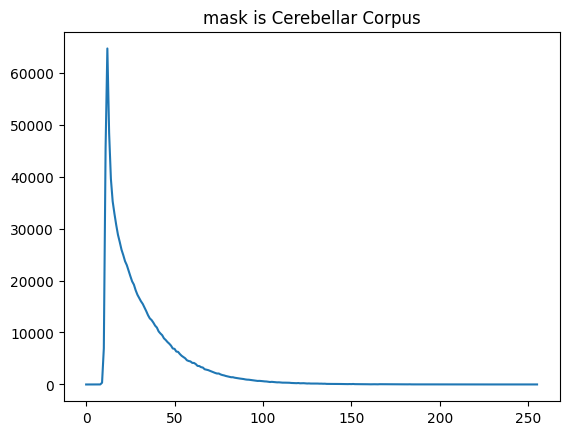

36 Granular Eminence


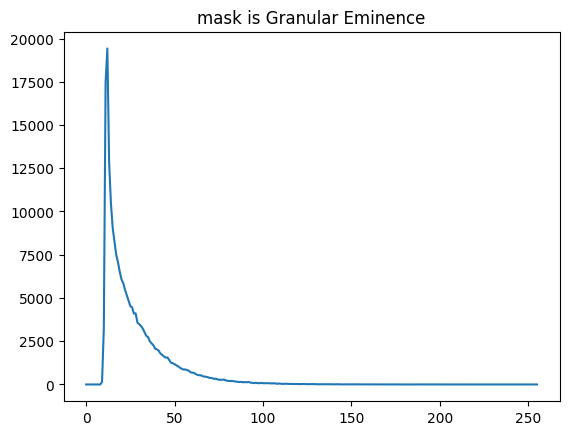

37 Medial Caudal Lobe


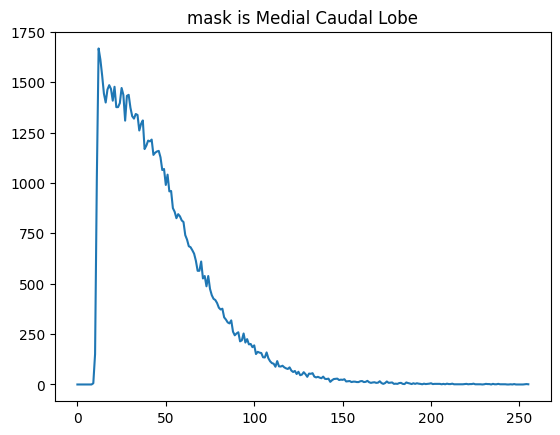

38 Rhombomere 1


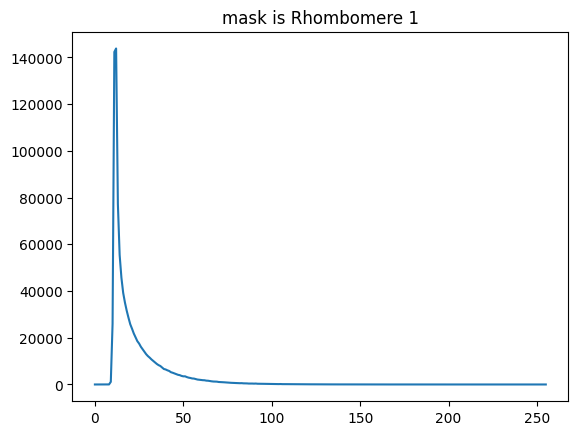

39 Raphe - Superior


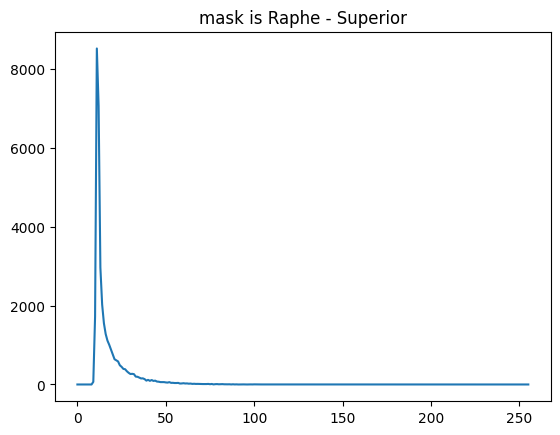

40 Interpeduncular Nucleus


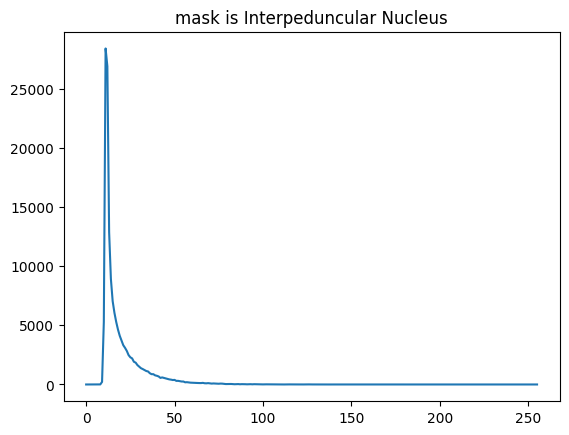

41 Locus Coeruleus


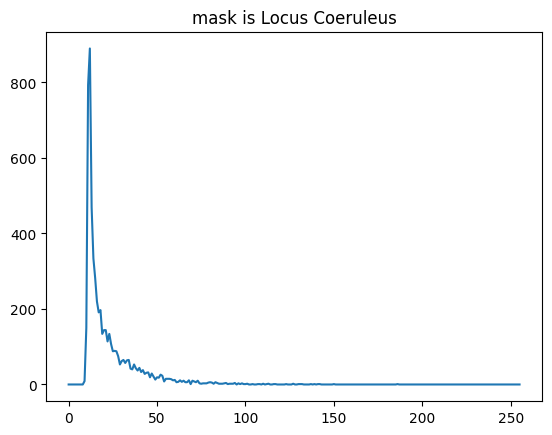

42 Rhombomere 2


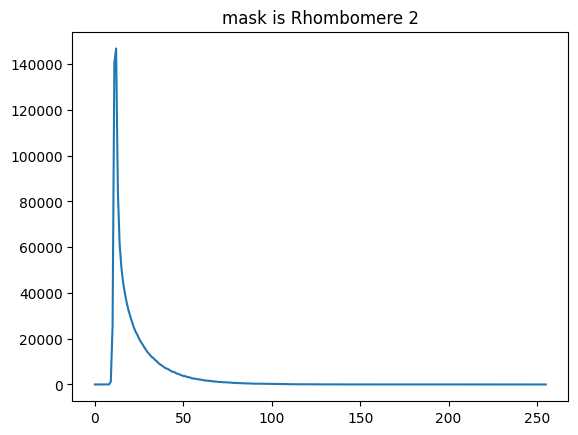

43 Raphe - Superior1


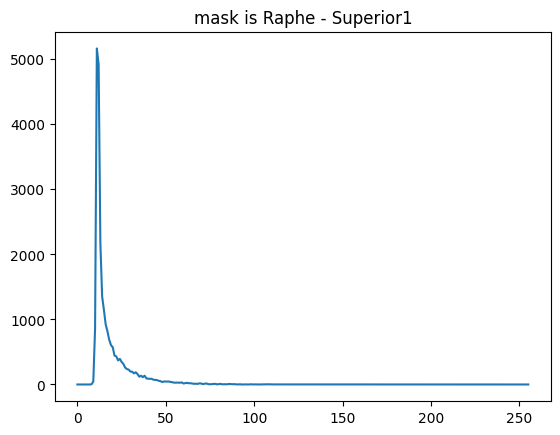

44 Locus Coeruleus1


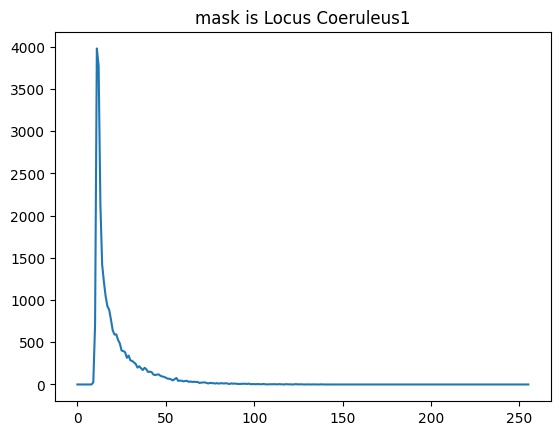

45 Rhombomere 3


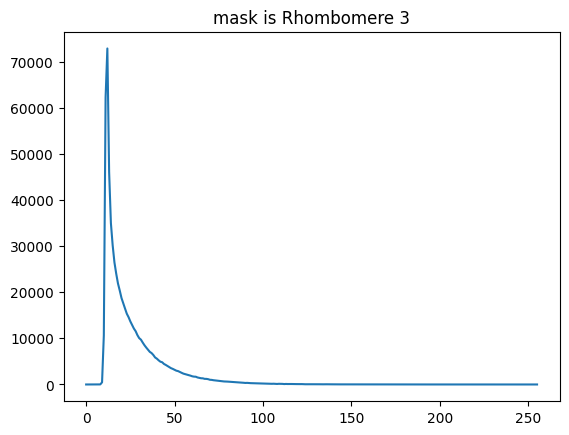

46 Raphe - Inferior


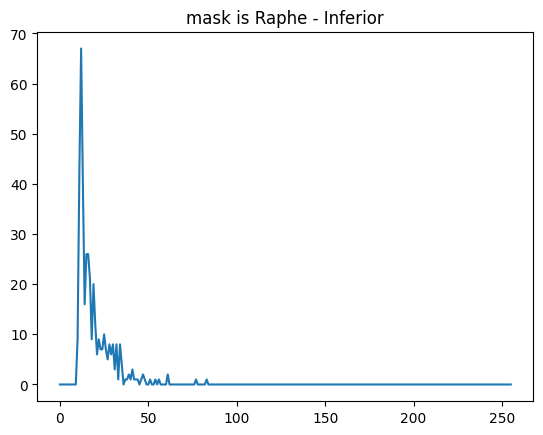

47 Rhombomere 4


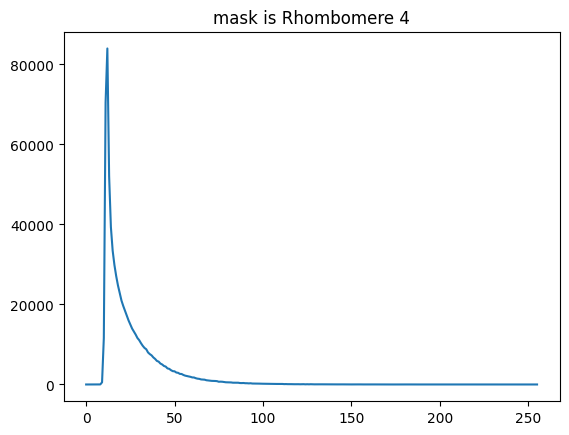

48 Raphe - Inferior1


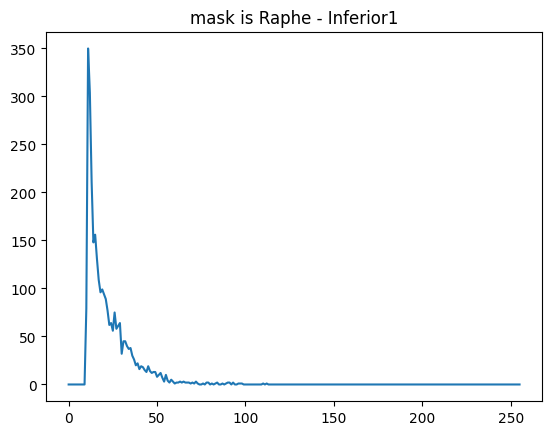

49 Rhombomere 5


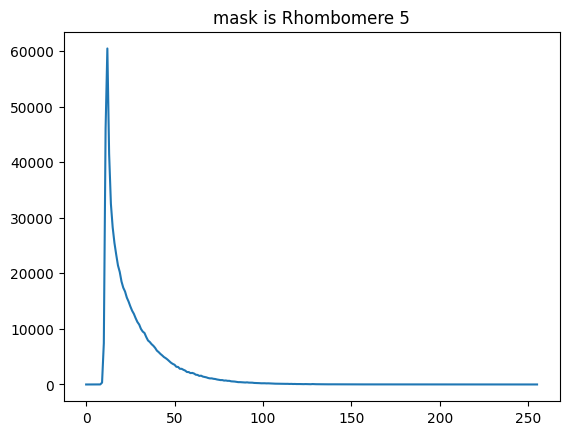

50 Raphe - Inferior2


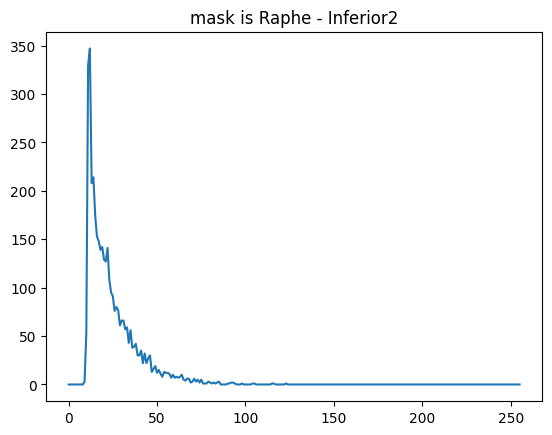

51 Rhombomere 6


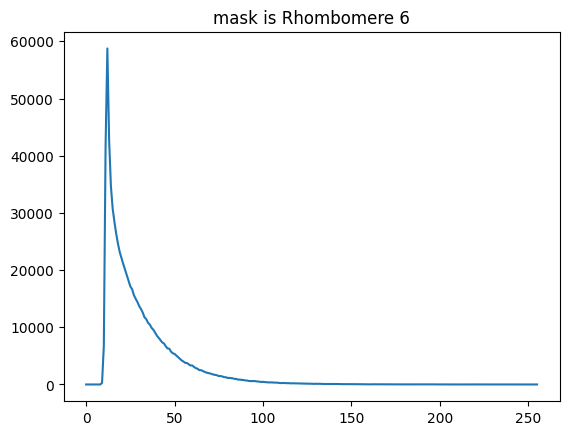

52 Raphe - Inferior3


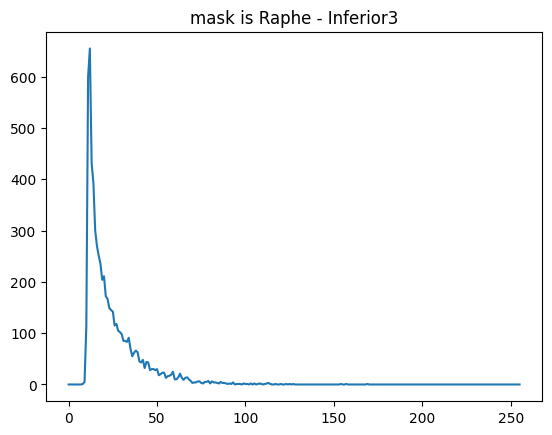

53 Rhombomere 7


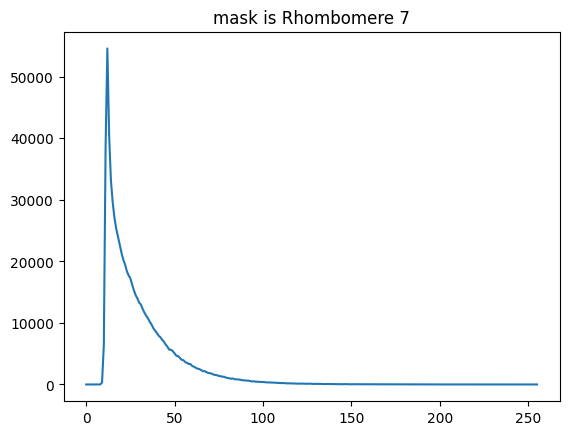

54 Raphe - Inferior4


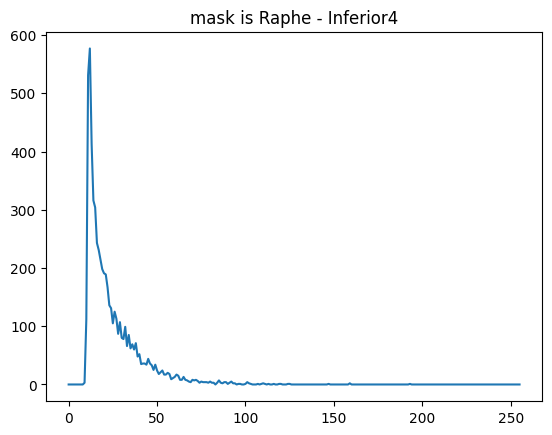

55 Caudal Hindbrain


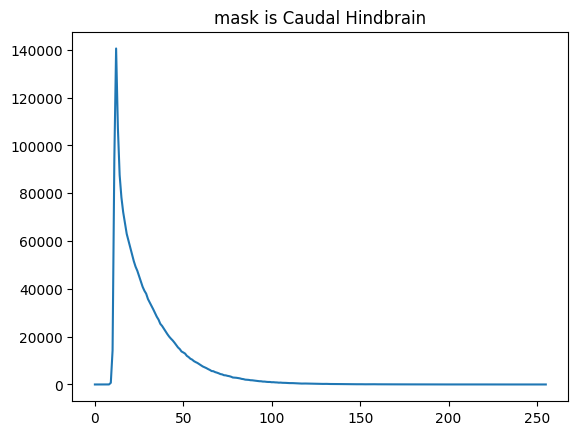

56 Area Postrema


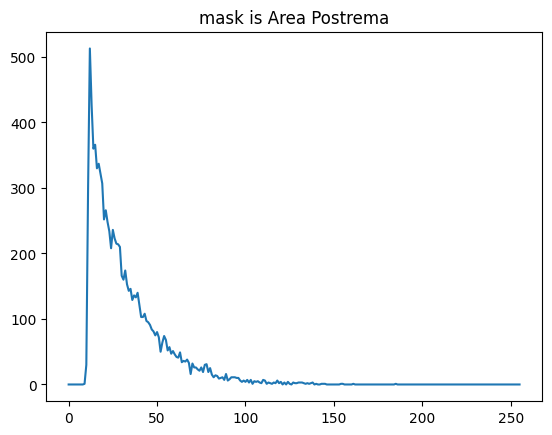

57 Inferior Olive


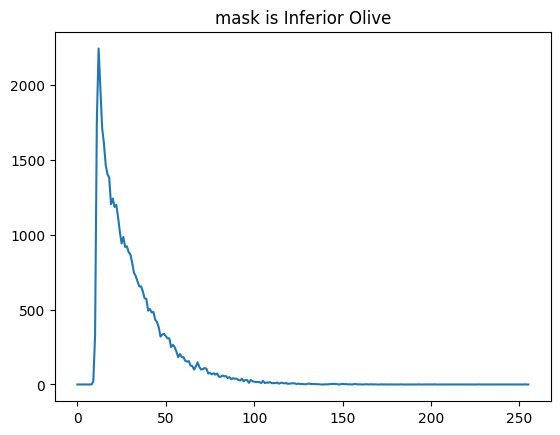

58 Lateral Reticular Nucleus


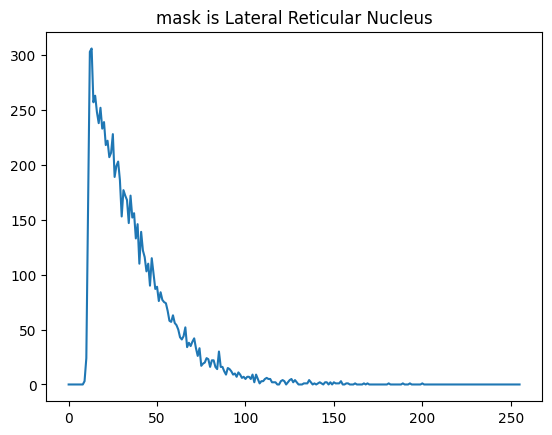

59 RoL-R1


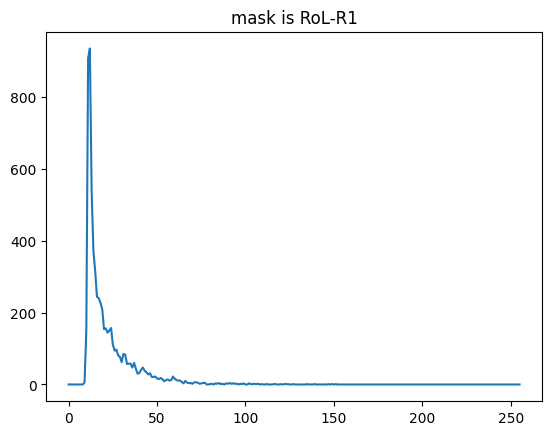

60 RoL2


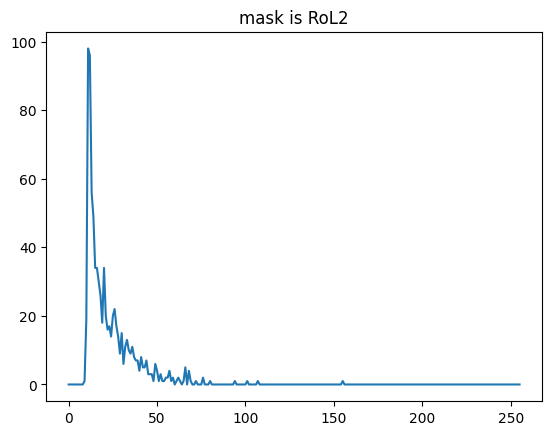

61 RoM1


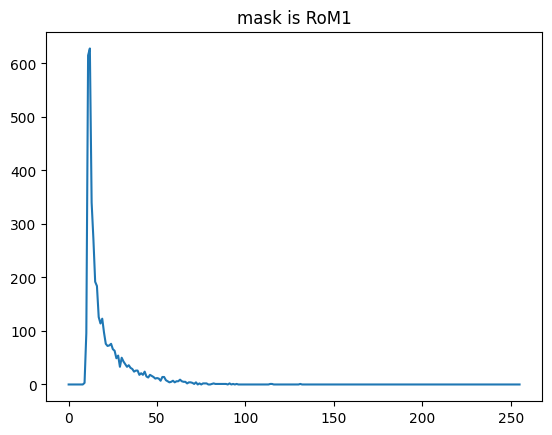

62 RoM2


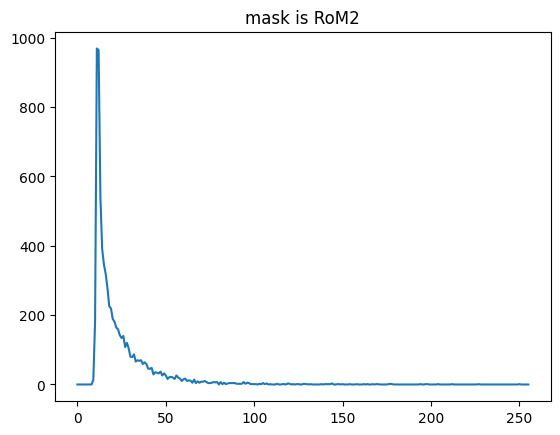

63 RoM3


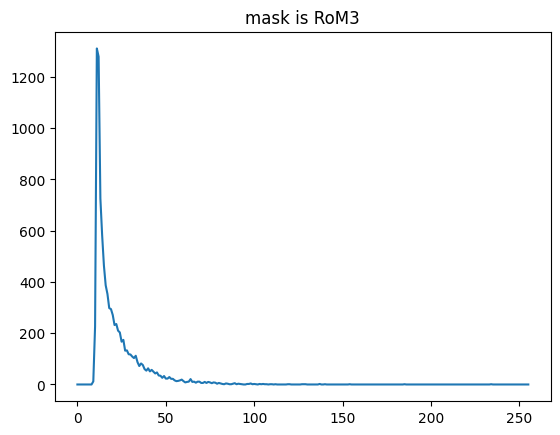

64 RoL3


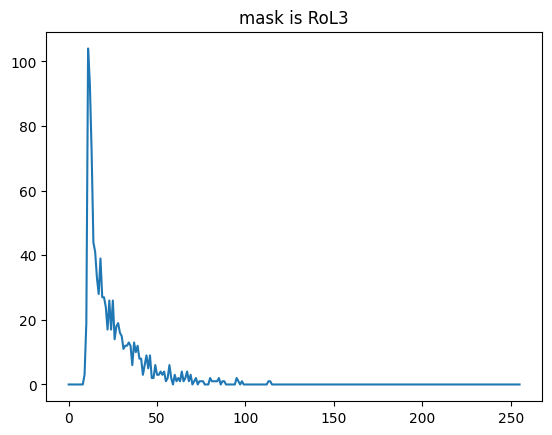

65 RoV3


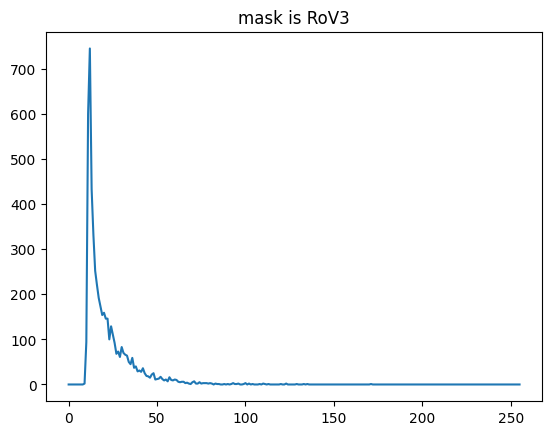

66 Mauthner


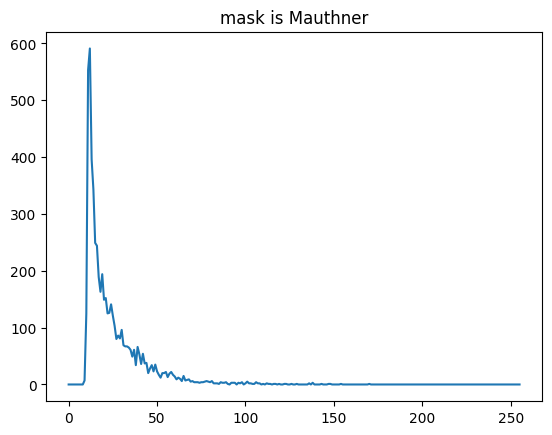

67 Mauthner Cell Axon Cap


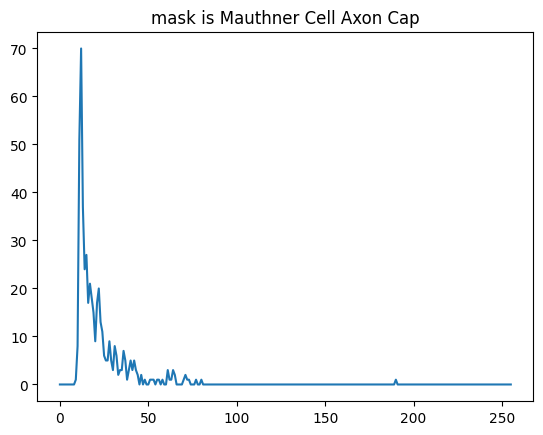

68 MiV1


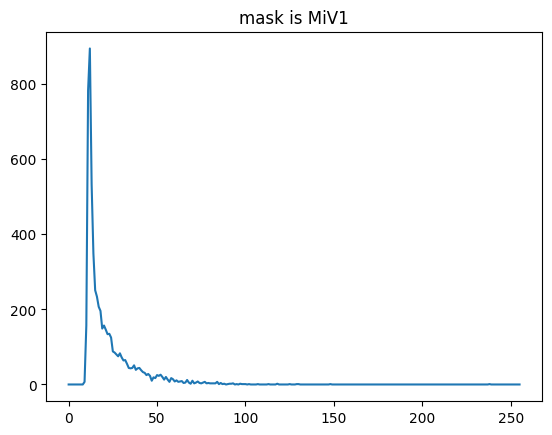

69 MiM1


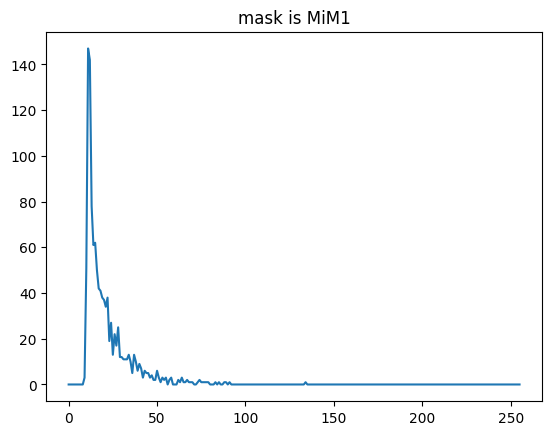

70 MiR1


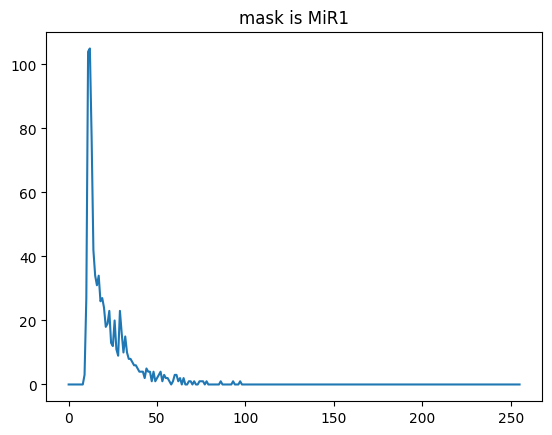

71 MiR2


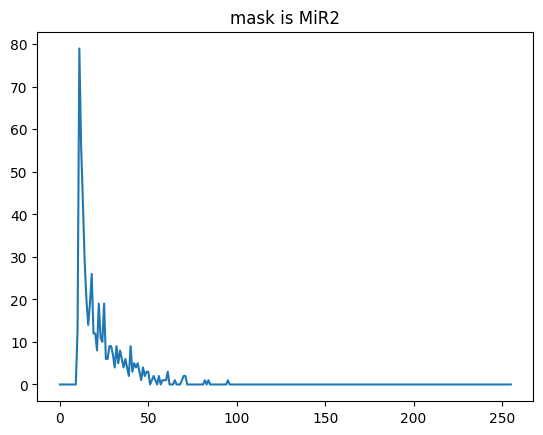

72 MiD2


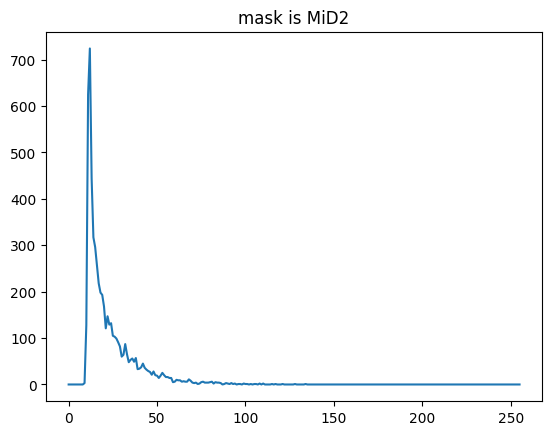

73 MiV2


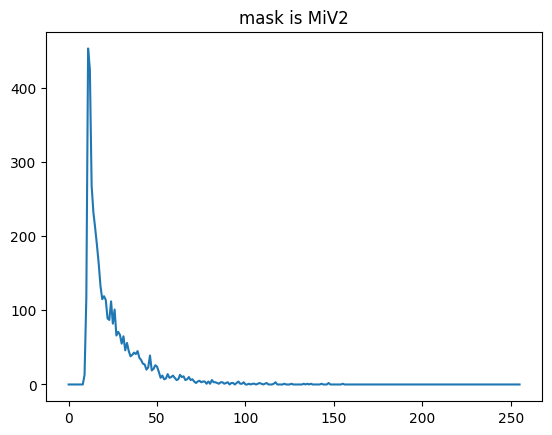

74 MiD3


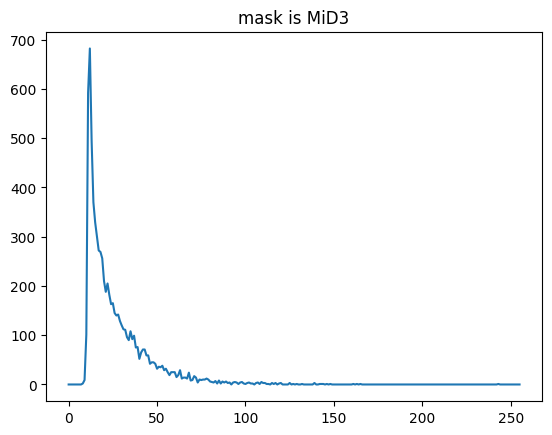

75 MiT


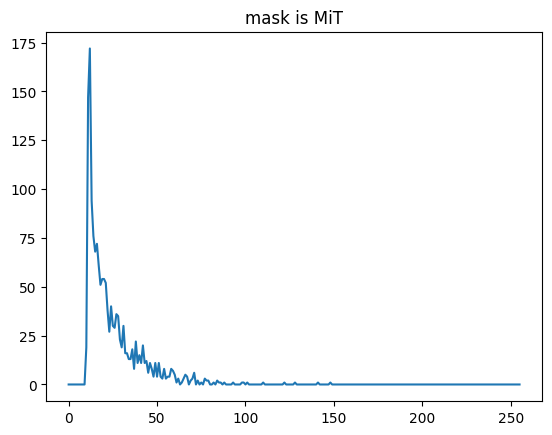

76 CaD


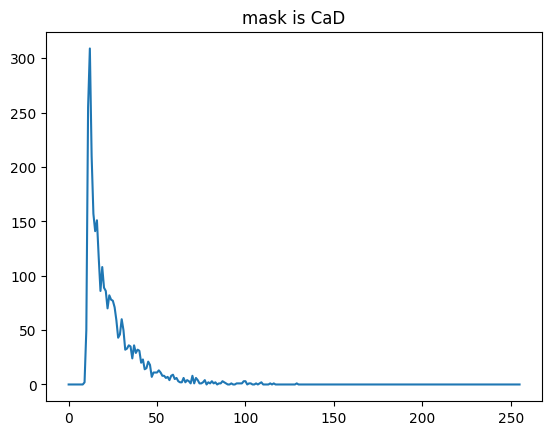

77 CaV


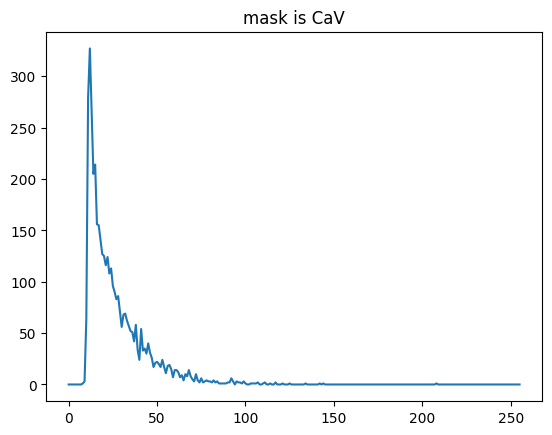

78 Spinal Backfill Vestibular Population


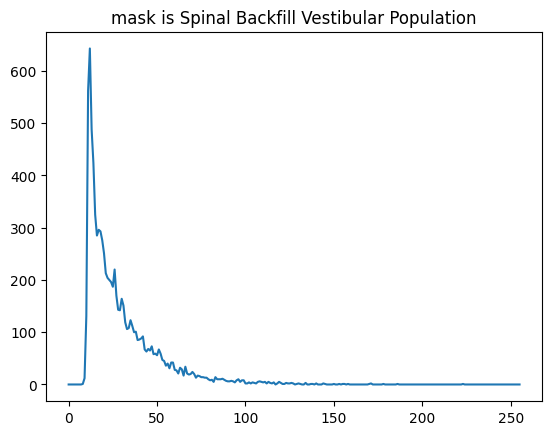

79 Tangential Vestibular Nucleus


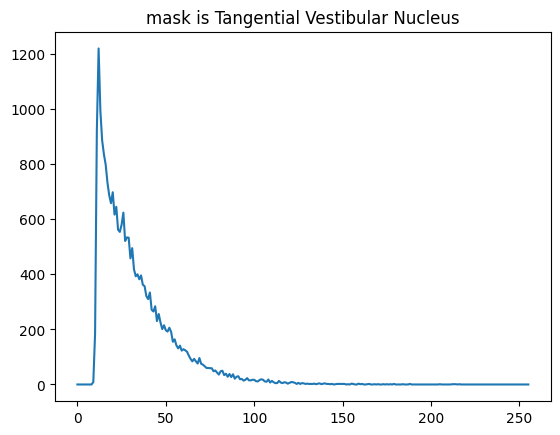

80 Tangential Vestibular Nucleus1


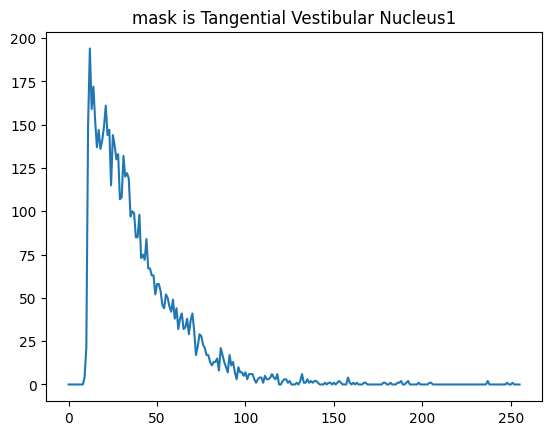

81 Medial Vestibular Nucleus


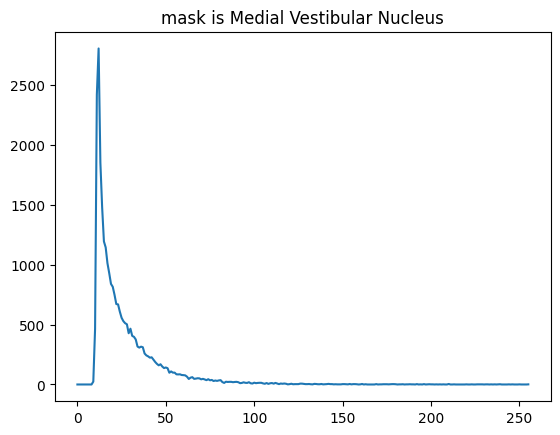

82 Medial Vestibular Nucleus1


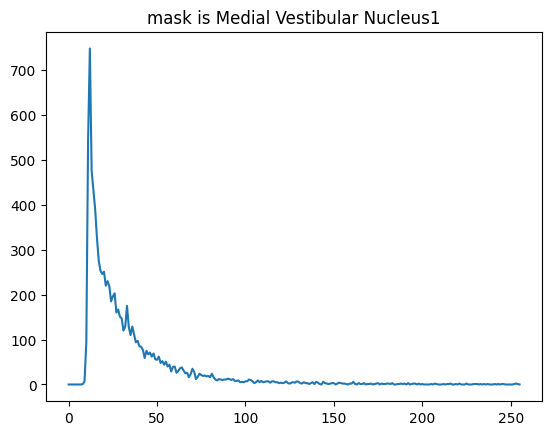

83 Oculomotor Nucleus nIV


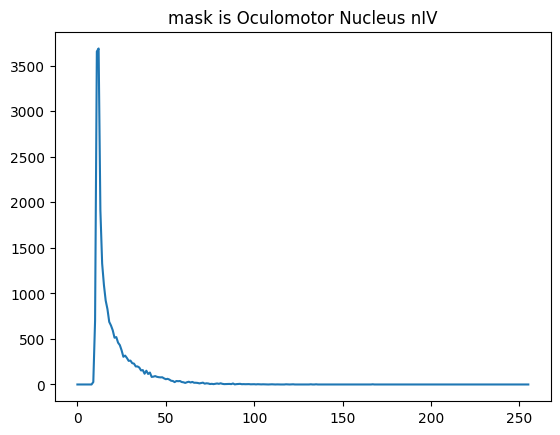

84 Anterior Cluster of nV Trigeminal Motorneurons


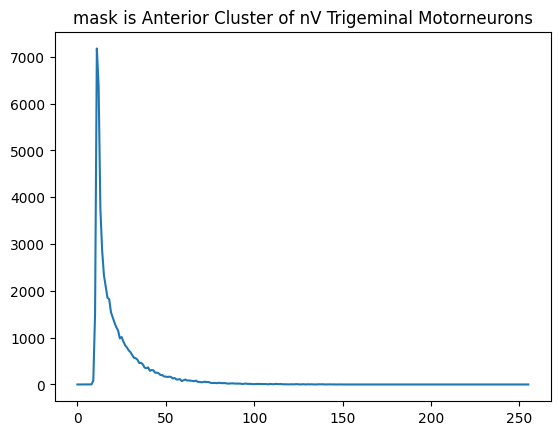

85 Posterior Cluster of nV Trigeminal Motorneurons


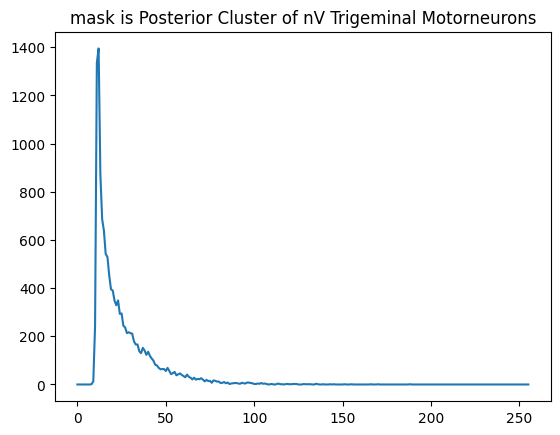

86 VII Facial Motor and octavolateralis efferent neurons


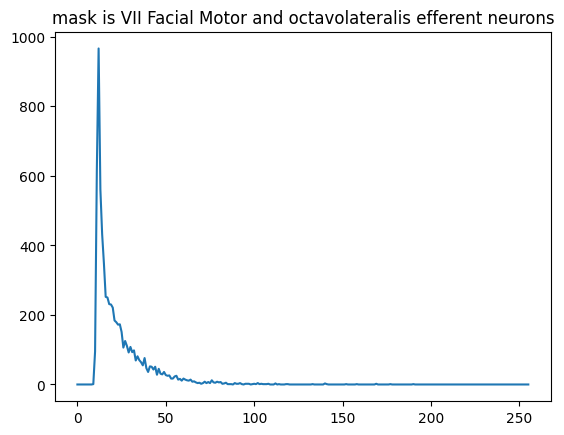

87 VII Facial Motor and octavolateralis efferent neurons1


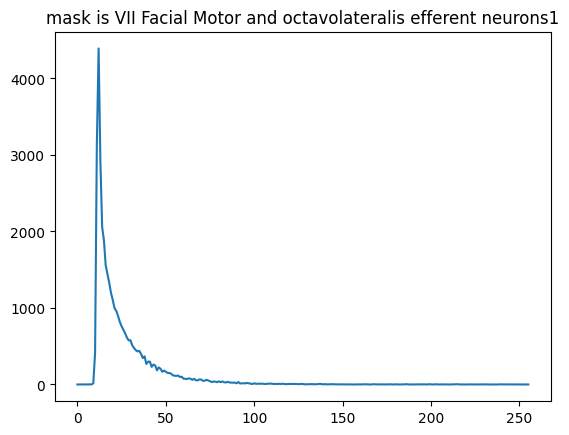

88 VII Facial Motor and octavolateralis efferent neurons2


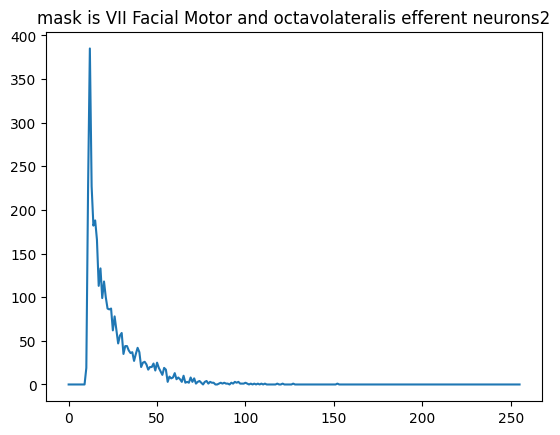

89 X Vagus motorneuron cluster


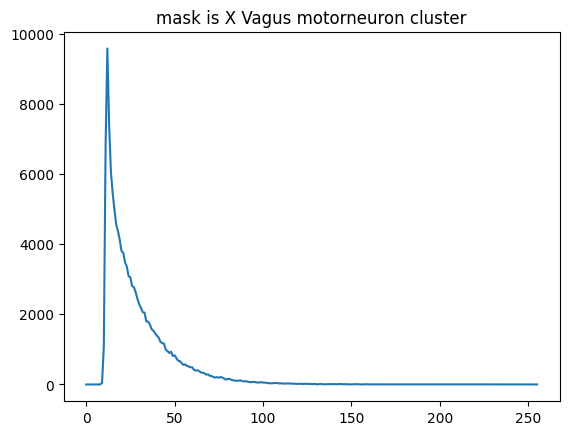

90 Olfactory Epithelium


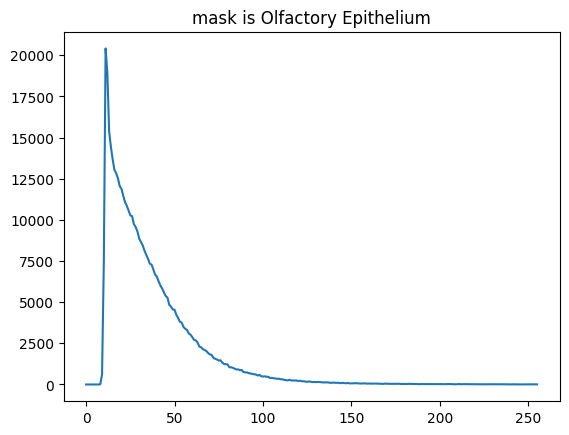

91 Facial Sensory Ganglion


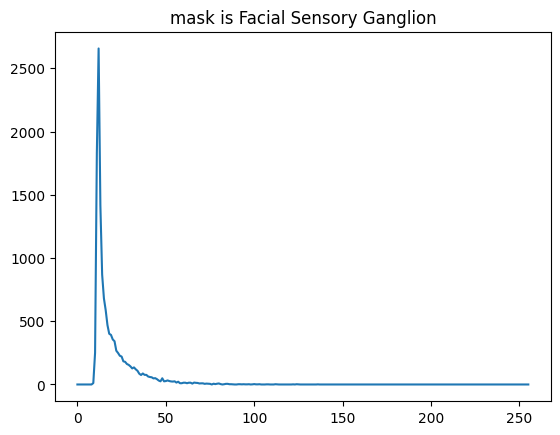

92 Facial glossopharyngeal ganglion


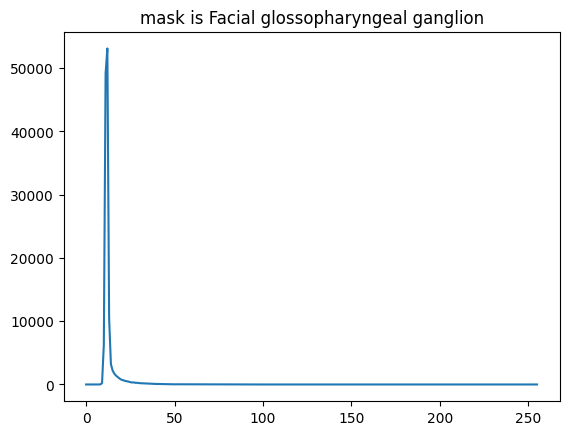

93 Statoacoustic Ganglion


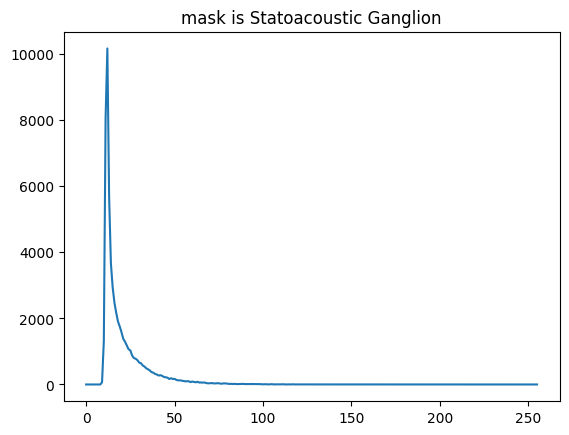

94 Trigeminal Ganglion


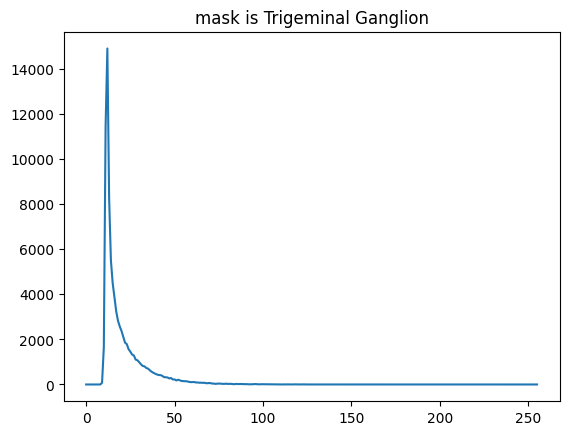

95 Anterior Lateral Line Ganglion


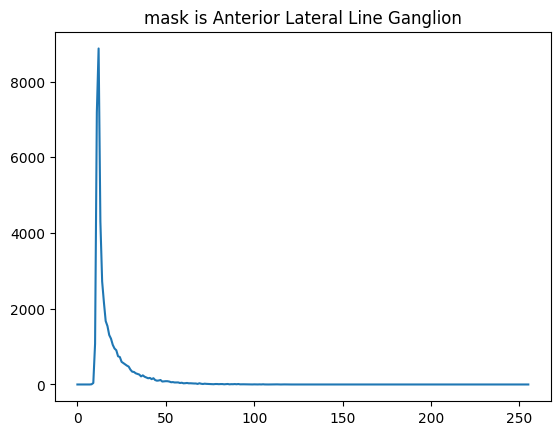

96 Posterior Lateral Line Ganglia


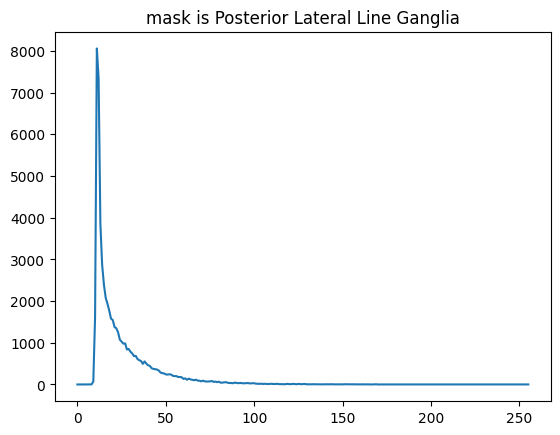

97 Lateral Line Neuromast D1


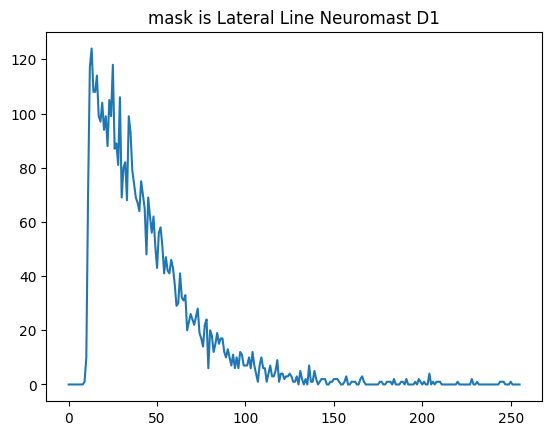

98 Lateral Line Neuromast D2


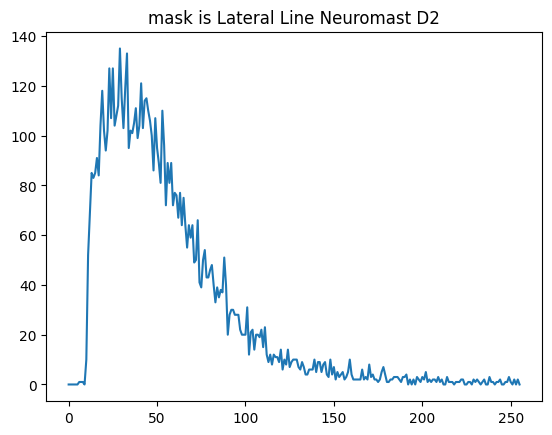

99 Lateral Line Neuromast N


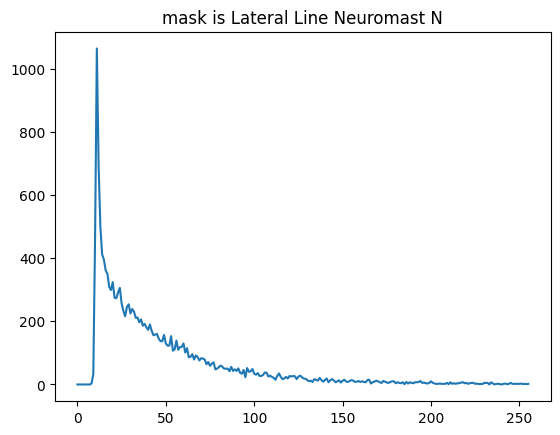

100 Lateral Line Neuromast O1


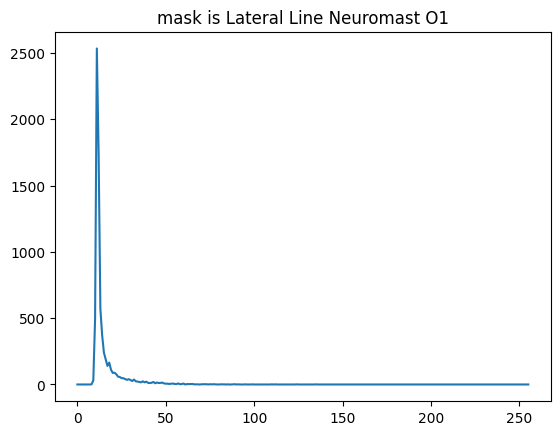

101 Lateral Line Neuromast OC1


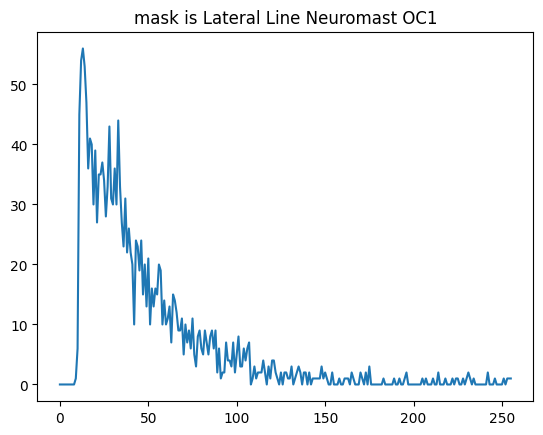

102 Lateral Line Neuromast SO1


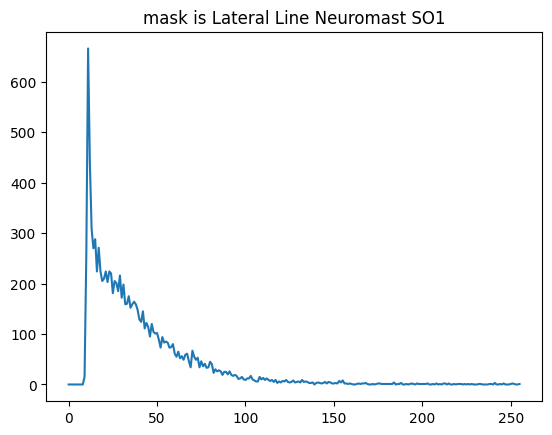

103 Lateral Line Neuromast SO2


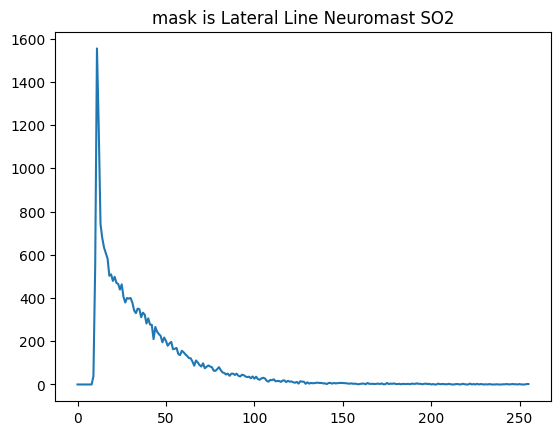

104 Lateral Line Neuromast SO3


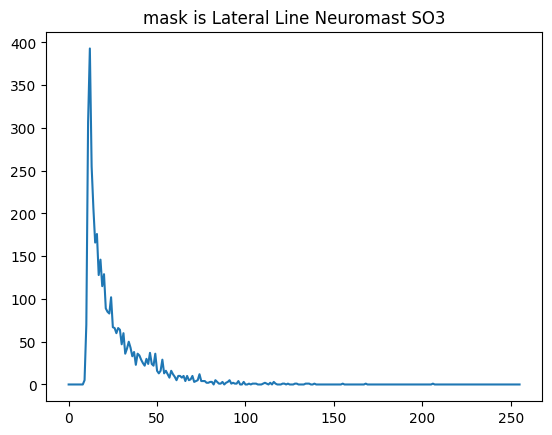

105 Vagal Ganglia


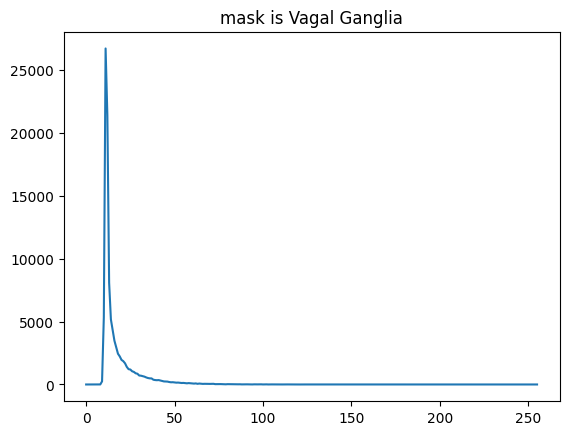

106 Telencephalon


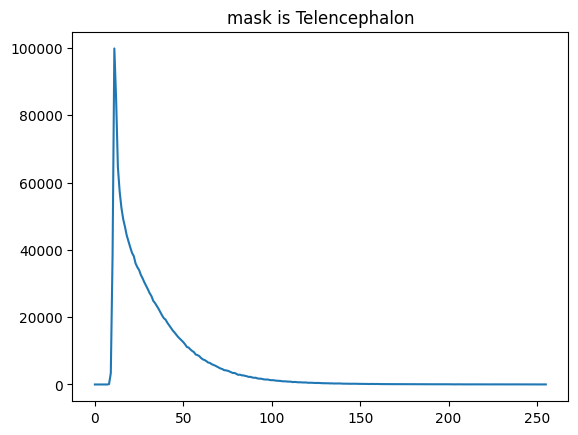

107 Diencephalon


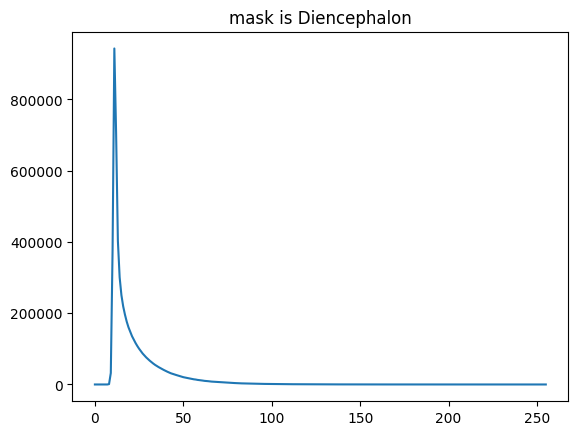

108 Midbrain


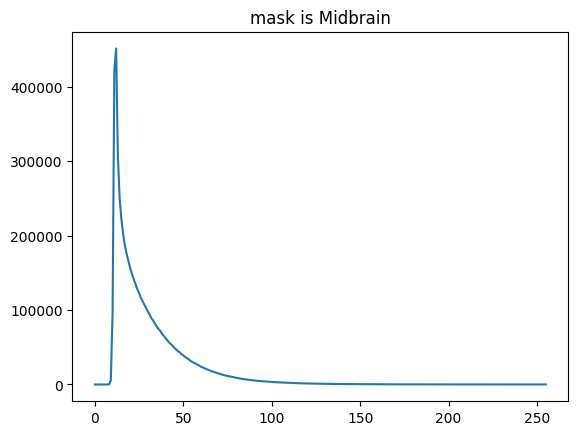

109 Hindbrain


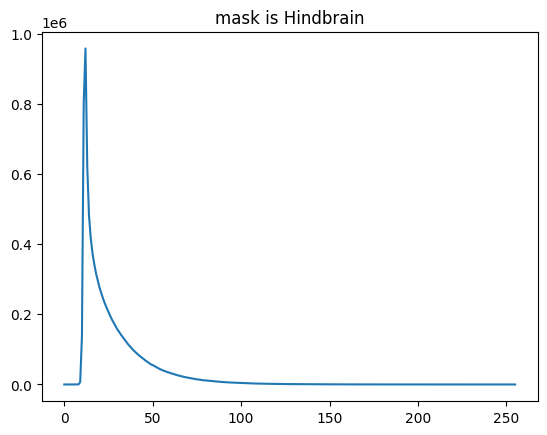

110 Spinal Cord


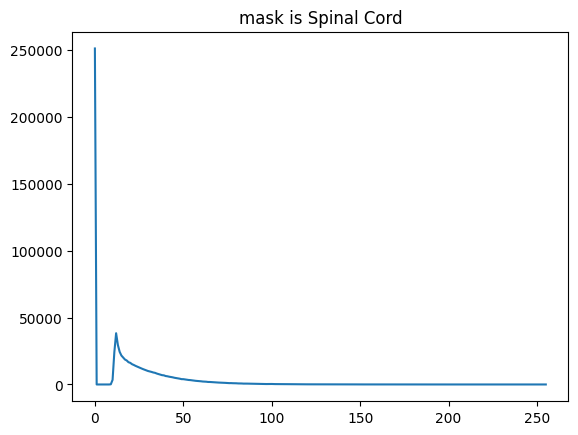

111 Ganglia


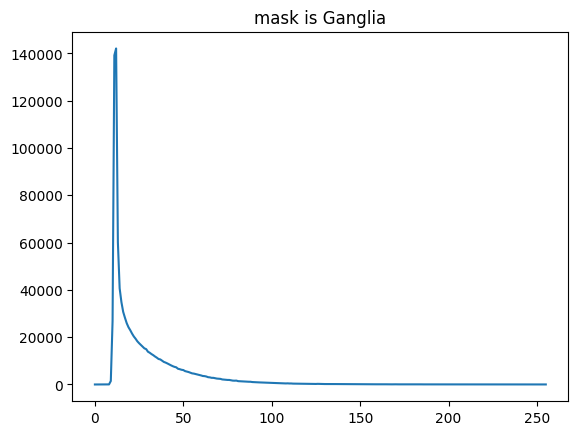

Saving to: C:\Users\cbriziol\Documents\final\C2-2025_06_20_Tapping_registered1tif_distribution_zebrafish_new.pkl


In [28]:
def test_compute_densities():
    specie="zebrafish"
    regions_folder=r"C:\Users\cbriziol\Desktop\2.latest_medaka_analysis_15_1_25\mece_masks\mece_masks"
    m_folder = r"C:\Users\cbriziol\Desktop"
    staining_stack_url=r"%sC2-2025_06_20_Tapping_registered1.tif" % m_folder
    save_folder=r"C:\Users\cbriziol\Documents\final"
    staining_name = r"C:\Users\cbriziol\Documents\final\C2-2025_06_20_Tapping_registered1tif"
    mask_file="mece_masks.json"
    all_masks=ut.read_json(mask_file)
    mini_masks=all_masks['mini_masks']
    macro_masks=all_masks['macro_masks']
    regions=mini_masks+macro_masks
    print(macro_masks)
    compute_densities(regions,regions_folder,save_folder, staining_name, specie, staining_stack_url)

test_compute_densities()

C:\Users\cbriziol\Documents\final/C2-2025_06_20_Tapping_registered1tif_distribution_zebrafish_new.pkl


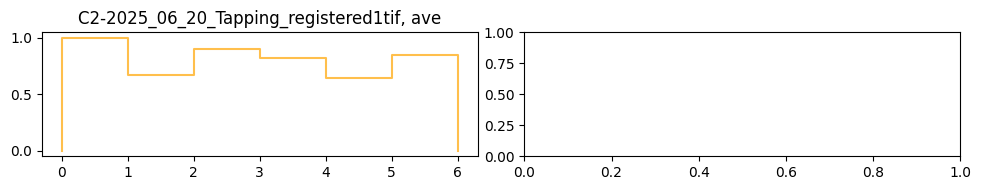

In [32]:
## make a figure for showing the Manhattan plot 
def test_ploting():
    staining_names_list = ["C2-2025_06_20_Tapping_registered1tif"]
    model_organism_list = ["zebrafish"]
    save_folder=r"C:\Users\cbriziol\Documents\final"
    precomputed_threshold_file=r"C:\Users\cbriziol\Desktop\2.latest_medaka_analysis_15_1_25\precomputed_thresholds_original.json"
    colors=["orange"]
    mask_file="mece_masks.json"
    all_masks=ut.read_json(mask_file)
    #regions=all_masks['mini_masks']
    regions=all_masks['macro_masks']
    manhattan_plots(precomputed_threshold_file, regions, colors, model_organism_list, staining_names_list, save_folder)
    
test_ploting()